#### Group Information

Group No: 

- Member 1: Lai Yicheng
- Member 2: Lee Ying Shen
- Member 3: Lim Ting Juin
- Member 4: Koay Chun Keat

#### Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)

# Set a random seed for reproducible results 
tf.random.set_seed(42)

TensorFlow version: 2.16.1


#### Load the dataset

In [2]:
ds = pd.read_csv('classification_dataset.csv')
ds.head()

,f1,f2,f3,f4,f5,label
0,1.286233,15.643743,-1.879915,-11.294839,15.245472,0
1,2.853398,0.129878,17.620669,3.945204,8.157459,1
2,3.285310,3.176560,12.610554,-6.063613,1.831887,0
3,2.019516,-1.967793,9.306435,-0.938714,-1.203038,0
4,-2.326527,3.453234,13.855478,-5.236421,1.547216,0


#### Define the loss function

In [3]:
def loss_fn(y_true, y_pred):
    """
    
    This function calculates the loss function using binary cross-entropy/ negative log likelihood.

    Parameters: y_true (float): The true labels, y_pred (float): The predicted labels

    Returns: result (float): The loss value

    """

    # add epsilon to prevent log(0)
    epsilon = 1e-7
    result = -tf.reduce_mean(y_true * tf.math.log(y_pred + epsilon) + (1 - y_true) * tf.math.log(1 - y_pred + epsilon))

    return result

#### Define function to perform prediction

In [4]:
def sigmoid(weighted_sum):
    """

    This function calculates the sigmoid function.

    Parameters: weighted_sum (float): The weighted sum of inputs.

    Returns: result (float): The result of the sigmoid function.
    
    """

    result = 1 / (1 + tf.exp(-weighted_sum))
    return result


def relu(weighted_sum):
    """

    This function calculates the ReLU function.

    Parameters: weighted_sum (float): The weighted sum of the inputs and weights.

    Returns: result (float): The result of the ReLU function.

    """

    return tf.maximum(0.0, weighted_sum)


# feedforward neural network (FNN)
def forward(inputs, weights, biases):
    """

    This function calculates the forward pass (predicts the label).

    Parameters: inputs (list): The input features, weights (list): The weights of the neural network.

    Returns: prediction (float): The probability of the sample belonging to the positive class.
        
    """

    weighted_sum_input = tf.matmul(inputs, weights["w_hidden"]) + biases["b_hidden"]
    output_hidden_activation = relu(weighted_sum_input)

    weighted_sum_activation = tf.matmul(output_hidden_activation, weights["w_output"]) + biases["b_output"]
    prediction = sigmoid(weighted_sum_activation)

    return prediction

#### Define function for model training
Display the training and validation loss values for each epoch of the training loop. The displayed value must be in 6 decimal places.<br>
Hint: <br>
Use `tf.GradientTape` to compute the gradients.

In [5]:
def train(x_train, y_train, weights, biases, learning_rate):
    """

    This function performs the forward pass, computes the gradient and update the weights and biases.

    Parameters: x_train (list): The input features, y_true (float): The true label, weights (list): The weights of the neural network, biases (list): The biases of the neural network, learning_rate (float): The learning rate.

    Returns: weights (list): loss (float): The loss value.

    """

    with tf.GradientTape() as t:
        # Perform the forward pass
        y_pred = forward(x_train, weights, biases)
        # Compute the loss
        loss = loss_fn(y_train, y_pred)

    # Perform the backward pass/ backprop

    # 1. Compute the gradients
    gradients = t.gradient(
        loss,
        [
            weights["w_hidden"],
            biases["b_hidden"],
            weights["w_output"],
            biases["b_output"],
        ],
    )

    # 2. Update the weights and biases
    weights["w_hidden"].assign_sub(learning_rate * gradients[0])
    biases["b_hidden"].assign_sub(learning_rate * gradients[1])
    weights["w_output"].assign_sub(learning_rate * gradients[2])
    biases["b_output"].assign_sub(learning_rate * gradients[3])

    return loss


def fit(
    x_train,
    y_train,
    x_valid,
    y_valid,
    weights,
    biases,
    learning_rate,
    epochs=10,
    batches=32,
    patience=5,
):
    """

    This function implements the training loop.

    Parameters: x_train (list): The input features for training, y_train (list): The true labels for training, x_valid (list): The input features for validation, y_valid (list): The true labels for validation, weights (list): The weights of the neural network, biases (list): The biases of the neural network, learning_rate (float): The learning rate, epochs (int): The number of epochs, batches (int): The number of batches, patience (int): The number of epochs to wait before early stopping.

    Returns: train_losses (list): The training losses, valid_losses (list): The validation losses.

    """

    train_losses = []
    valid_losses = []
    epochs_no_improve = 0
    min_val_loss = np.inf

    for i in range(epochs):
        # Mini-batch gradient descent implementation for training
        for j in range(0, len(x_train), batches):
            x_train_batch = x_train[j : j + batches]
            y_train_batch = y_train[j : j + batches]
            train_loss = train(x_train_batch, y_train_batch, weights, biases, learning_rate)
        train_losses.append(train_loss)

        # Evaluate validation loss after each epoch to detect overfitting
        y_pred = forward(x_valid, weights, biases)
        valid_loss = loss_fn(y_valid, y_pred)
        valid_losses.append(valid_loss)

        # Early stopping regularization
        if valid_losses[-1] < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = valid_losses[-1]
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at epoch {i}")
                break

        # format the loss to 6 decimal places
        formatted_train_loss = f"{train_losses[-1]:.6f}"
        formatted_valid_loss = f"{valid_losses[-1]:.6f}"
        print(
            f"Epoch: {i}, Train Loss: {formatted_train_loss}, Validation Loss: {formatted_valid_loss}"
        )

    return train_losses, valid_losses

#### Define the tensors to hold the weights and biases (create the model)
Hint: <br>
Use `tf.Variable` to create the tensors.<br>
Put the tensors in a list.

In [6]:
ds_tf = tf.Variable(ds)
ds_tf

np.random.seed(42)

num_input_nodes = 5
num_hidden_nodes = 5
num_output_nodes = 1

weights = {
  "w_hidden": tf.Variable(np.random.randn(num_input_nodes, num_hidden_nodes)),  # Weight matrix for hidden layer
  "w_output": tf.Variable(np.random.randn(num_hidden_nodes, num_output_nodes)),  # Weight matrix for output layer
}

biases = {
  "b_hidden": tf.Variable(np.random.randn(1,num_hidden_nodes)),  # Bias vector for hidden layer
  "b_output": tf.Variable(np.random.randn(num_output_nodes)),  # Bias vector for output layer
}

#### Split the dataset
The ratio of training and test is 7:1:2.

In [7]:
ds_shuffle = tf.random.shuffle(ds_tf, seed=42) # shuffle the dataset
train_size = int(0.7 * len(ds))
valid_size = int(0.1 * len(ds))
test_size = int(0.2 * len(ds))
train_data, valid_data, test_data = ds_shuffle[:train_size], ds_shuffle[train_size:train_size + valid_size], ds_shuffle[train_size + valid_size:]

x_train, y_train = train_data[:, :-1], train_data[:, -1]
x_valid, y_valid = valid_data[:, :-1], valid_data[:, -1]
x_test, y_test = test_data[:, :-1], test_data[:, -1]

#### Normalize the data

In [8]:
norm_x_train = (x_train - tf.reduce_mean(x_train, axis=0)) / tf.math.reduce_std(x_train, axis=0)
norm_x_valid = (x_valid - tf.reduce_mean(x_valid, axis=0)) / tf.math.reduce_std(x_valid, axis=0)
norm_x_test = (x_test - tf.reduce_mean(x_test, axis=0)) / tf.math.reduce_std(x_test, axis=0)

#### Train the model

In [9]:
# Train the model
train_losses, valid_losses = fit(norm_x_train, y_train, norm_x_valid, y_valid, weights, biases, learning_rate=0.01, epochs=30, batches=32, patience=3)

Epoch: 0, Train Loss: 1.673174, Validation Loss: 1.797552
Epoch: 1, Train Loss: 1.343956, Validation Loss: 1.433993
Epoch: 2, Train Loss: 1.067839, Validation Loss: 1.129399
Epoch: 3, Train Loss: 0.876396, Validation Loss: 0.925149
Epoch: 4, Train Loss: 0.784223, Validation Loss: 0.834318
Epoch: 5, Train Loss: 0.749086, Validation Loss: 0.800669
Epoch: 6, Train Loss: 0.734922, Validation Loss: 0.785556
Epoch: 7, Train Loss: 0.727893, Validation Loss: 0.776406
Epoch: 8, Train Loss: 0.723534, Validation Loss: 0.769560
Epoch: 9, Train Loss: 0.720348, Validation Loss: 0.763861
Epoch: 10, Train Loss: 0.717776, Validation Loss: 0.758869
Epoch: 11, Train Loss: 0.715596, Validation Loss: 0.754418
Epoch: 12, Train Loss: 0.713689, Validation Loss: 0.750436
Epoch: 13, Train Loss: 0.711997, Validation Loss: 0.746800
Epoch: 14, Train Loss: 0.710487, Validation Loss: 0.743472
Epoch: 15, Train Loss: 0.709125, Validation Loss: 0.740423
Epoch: 16, Train Loss: 0.707857, Validation Loss: 0.737622
Epoch: 

#### Display the training loss and validation loss against epoch graph

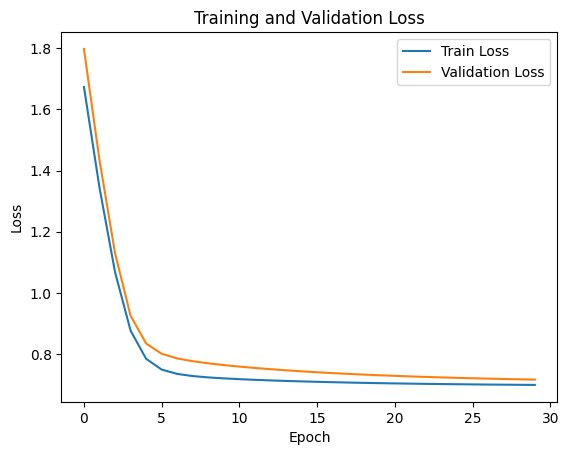

In [10]:
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Predict the test set

In [11]:
y_pred = forward(norm_x_test, weights, biases)

#### Display the confusion matrix and the classification report

In [12]:
# assuming threshold is 0.5 and positive class is 1
y_pred = tf.where(y_pred > 0.5, 1, 0)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[74 27]
 [78 21]]
              precision    recall  f1-score   support

         0.0       0.49      0.73      0.58       101
         1.0       0.44      0.21      0.29        99

    accuracy                           0.48       200
   macro avg       0.46      0.47      0.44       200
weighted avg       0.46      0.47      0.44       200

